### Coding 3: Final Assignment - Bechdel Test Investigation
#### Peter Endes-Nagy and Nadine Levin

*Resources* 
1. https://data.world/sharon/bechdel-test
2. https://bechdeltest.com/
3. https://www.kaggle.com/rounakbanik/the-movies-dataset
4. https://www.themoviedb.org/documentation/api

In [209]:
import numpy as np
import pandas as pd
import requests
import json
import time

##### API Section

In [25]:
#API for ids (not sure if it's needed)
api_movie_ids_df = pd.read_json("http://bechdeltest.com/api/v1/getAllMovieIds")
print(api_movie_ids_df)

       imdbid     id
0              10029
1              10131
2              10155
3     0000001   9651
4     0000002   9632
...       ...    ...
9412  9844522  10043
9413  9866072   9839
9414  9893250   9491
9415  9900092  10010
9416  9902160   9452

[9417 rows x 2 columns]


In [231]:
#API for rating, imdbid, title, id, and year (not sure if it's needed as well)
bechdel_api_all_movies_df = pd.read_json('http://bechdeltest.com/api/v1/getAllMovies')
bechdel_api_all_movies_df['year'] = pd.to_datetime(bechdel_api_all_movies_df['year'], format='%Y')
bechdel_api_all_movies_df['rating'] = bechdel_api_all_movies_df['rating'].astype('category', copy=False)
print(bechdel_api_all_movies_df)

        imdbid     id                       title       year rating
0      3155794   9602            Passage de Venus 1874-01-01      0
1     14495706   9804           La Rosace Magique 1877-01-01      0
2      2221420   9603  Sallie Gardner at a Gallop 1878-01-01      0
3     12592084   9806           Le singe musicien 1878-01-01      0
4      7816420   9816     Athlete Swinging a Pick 1881-01-01      0
...        ...    ...                         ...        ...    ...
9412   4995540  10199          Being The Ricardos 2021-01-01      3
9413  11127680  10200               Boiling Point 2021-01-01      3
9414  10293406  10202       Power of the Dog, The 2021-01-01      0
9415  11389748  10206                        Mass 2021-01-01      3
9416   8356942  10195                    355, The 2022-01-01      3

[9417 rows x 5 columns]


In [210]:
numeric_cols = ['year' , 'rating' , 'lgbtq_keywords_num' , 'keywords_num']

for i in numeric_cols:
    bechdel_films_ifgay[i] = pd.to_numeric(bechdel_films_ifgay[i])
    
bechdel_films_ifgay = bechdel_films_ifgay[bechdel_films_ifgay.imdbid.notnull()].reset_index()

In [224]:
#DO NOT RERUN
resp_json_dict = np.load('peter_v1/movie_data_dict.npy', allow_pickle = True ).item()
resp_json_dict_chunk4 = np.load('resp_json_dict2.npy', allow_pickle = True ).item() 
resp_json_dict.update(resp_json_dict_chunk4)

5417

In [276]:
resp_json_dict = np.load('resp_json_dict.npy', allow_pickle = True ).item() 

In [250]:
print(resp_json_dict)

{'0280460': {'Title': 'The Banger Sisters', 'Year': '2002', 'Rated': 'R', 'Released': '20 Sep 2002', 'Runtime': '98 min', 'Genre': 'Comedy, Drama', 'Director': 'Bob Dolman', 'Writer': 'Bob Dolman', 'Actors': 'Susan Sarandon, Goldie Hawn, Geoffrey Rush', 'Plot': 'Lavinia and Suzette, former rock groupies and best friends, reconnect after twenty years; one is still as wild as ever, while the other has adopted a more conservative lifestyle.', 'Language': 'English', 'Country': 'United States', 'Awards': '1 win & 1 nomination', 'Poster': 'https://m.media-amazon.com/images/M/MV5BZjA1OTQxNGEtNTRjNi00MWIwLWEyZGYtNGRjOGEwNzE5OWU2XkEyXkFqcGdeQXVyMTQxNzMzNDI@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '5.7/10'}, {'Source': 'Rotten Tomatoes', 'Value': '48%'}, {'Source': 'Metacritic', 'Value': '48/100'}], 'Metascore': '48', 'imdbRating': '5.7', 'imdbVotes': '16,480', 'imdbID': 'tt0280460', 'Type': 'movie', 'DVD': '14 Oct 2003', 'BoxOffice': '$30,307,416', 'Production

In [222]:
list_of_imdb_ids = bechdel_films_ifgay['imdbid'].to_list()

API_keys = ['bdcace91' , 
           '5b1dd383' , 
           '18eecc1c' , 
           '59f678e9' , 
           'ea5d7d0c',
           '7ecc3518' , 
           'efbb5d26' , 
           '101156d4' , 
           '78906128' , 
           'c0bebd87']

len(list_of_imdb_ids)

9414

In [225]:
list_of_imdb_ids = [e for e in bechdel_films_ifgay['imdbid'].to_list() if e not in list(resp_json_dict.keys()) ]
len(list_of_imdb_ids)

3996

In [226]:
for imdb_id in list_of_imdb_ids:
    try:
        url = 'http://www.omdbapi.com/?i=tt' + imdb_id + '&apikey=' + API_keys[0]
        resp = requests.get(url)        
        resp_json = json.loads(resp.text)
        
        #if we happen to run into API limit (1.000 calls per day) and the error is because of the limit,
        # this chunk overwrites the API_keys list, drops the first key we are using until no limit issue
        while (resp_json['Response'] == 'False' and resp_json['Error'] == 'Request limit reached!'):
            API_keys = API_keys[1:]
            url = 'http://www.omdbapi.com/?i=tt' + imdb_id + '&apikey=' + str(API_keys[0])
            resp = requests.get(url)        
            resp_json = json.loads(resp.text)    
        #save the json response into our dictionary    
        resp_json_dict[imdb_id] = resp_json
    
    #if we encounter any type of errors, let's just print it, so the code running for hours doesn't get interrupted.
    #we can return to the missing IMDb Id's later if feeling so
    except Exception as e: 
        print("For IMDb Id: " + str(imdb_id))
        print(e)

For IMDb Id: 0272152
list index out of range
For IMDb Id: 0283015
list index out of range
For IMDb Id: 0118589
list index out of range
For IMDb Id: 0256692
list index out of range
For IMDb Id: 0348225
list index out of range
For IMDb Id: 0209163
list index out of range
For IMDb Id: 0278488
list index out of range
For IMDb Id: 0277371
list index out of range
For IMDb Id: 0246278
list index out of range
For IMDb Id: 0256009
list index out of range
For IMDb Id: 0286751
list index out of range
For IMDb Id: 0265632
list index out of range
For IMDb Id: 0256524
list index out of range
For IMDb Id: 0279977
list index out of range
For IMDb Id: 0271972
list index out of range
For IMDb Id: 0264508
list index out of range
For IMDb Id: 0273300
list index out of range
For IMDb Id: 0159273
list index out of range
For IMDb Id: 0266915
list index out of range
For IMDb Id: 0287986
list index out of range
For IMDb Id: 0218922
list index out of range
For IMDb Id: 0259685
list index out of range
For IMDb I

In [227]:
len(resp_json_dict)
#np.save('resp_json_dict.npy', resp_json_dict)

9279

##### CSV Section (We can load more CSVs if needed later on)

In [192]:
#https://cran.r-project.org/web/packages/ggplot2movies/index.html (I downloaded the data in RStudio)
csv_ggplot2movies_df = pd.read_csv('https://raw.githubusercontent.com/nadineisabel/ceu_coding3-final_project/main/data/r_ggplor2movies.csv')
print(csv_ggplot2movies_df)

                          title  year  length      budget  rating  votes  \
0                             $  1971     121         NaN     6.4    348   
1             $1000 a Touchdown  1939      71         NaN     6.0     20   
2        $21 a Day Once a Month  1941       7         NaN     8.2      5   
3                       $40,000  1996      70         NaN     8.2      6   
4      $50,000 Climax Show, The  1975      71         NaN     3.4     17   
...                         ...   ...     ...         ...     ...    ...   
58783                 tom thumb  1958      98         NaN     6.5    274   
58784               www.XXX.com  2003     105         NaN     1.1     12   
58785    www.hellssoapopera.com  1999     100         NaN     6.6      5   
58786                       xXx  2002     132  85000000.0     5.5  18514   
58787   xXx: State of the Union  2005     101  87000000.0     3.9   1584   

         r1    r2    r3    r4  ...    r9   r10   mpaa  Action  Animation  \
0       4.5

In [193]:
#Loading gay Bechdel test films from scraping notebook
bechdel_films_ifgay = pd.read_csv('/Users/nadineisabellevin/CEU/WinterSemester/python_3/Final_Project/peter_v1/bechdel_films_ifgay.csv', dtype = str).drop("Unnamed: 0" , 1 )
print(bechdel_films_ifgay)

                           title     id  year    imdbid rating  \
0               Passage de Venus   9602  1874   3155794      0   
1              La Rosace Magique   9804  1877  14495706      0   
2     Sallie Gardner at a Gallop   9603  1878   2221420      0   
3              Le singe musicien   9806  1878  12592084      0   
4        Athlete Swinging a Pick   9816  1881   7816420      0   
...                          ...    ...   ...       ...    ...   
9412          Being The Ricardos  10199  2021   4995540      3   
9413               Boiling Point  10200  2021  11127680      3   
9414       Power of the Dog, The  10202  2021  10293406      0   
9415                        Mass  10206  2021  11389748      3   
9416                    355, The  10195  2022   8356942      3   

     lgbtq_keywords_num keywords_num  
0                     0            9  
1                     0            1  
2                     0            7  
3                     0            8  
4           

/var/folders/xg/n4kbhz8536n26ctz3c749pd80000gn/T/ipykernel_57720/1301596291.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  bechdel_films_ifgay = pd.read_csv('/Users/nadineisabellevin/CEU/WinterSemester/python_3/Final_Project/peter_v1/bechdel_films_ifgay.csv', dtype = str).drop("Unnamed: 0" , 1 )


##### Gender Prediction Library Section (We can use this on director names, actor names, etc.)

In [120]:
#https://pypi.org/project/gender-guesser/
#!pip install gender-guesser
import gender_guesser.detector as gen

In [259]:
d.get_gender("Jan", "germany")

'male'

In [284]:
d = gen.Detector()
genders = []
firstNames = imdb_api_df['Director'].str.split().str.get(0)
for i in firstNames[0:len(firstNames)]:
    if d.get_gender(i) == 'male':
        genders.append('male')
    elif d.get_gender(i) == 'female':
        genders.append('female')
    elif d.get_gender(i) == 'mostly_female':
        genders.append('female')
    elif d.get_gender(i) == 'mostly_male':
        genders.append('male')
    else:
        genders.append('unknown')
imdb_api_df['Gender'] = genders

imdb_api_df['Male'] = imdb_api_df['Gender'].map( {'male':1, 'female':0} )
print(imdb_api_df['Gender'].value_counts())

male       7522
female     1033
unknown     855
Name: Gender, dtype: int64


##### Dataframe Creation

In [281]:
imdb_api_df = pd.DataFrame.from_dict(resp_json_dict, orient='index')
imdb_api_df.index.names = ['imdb_id']
imdb_api_df.reset_index(inplace=True)
print(imdb_api_df)

       imdb_id          Title  Year      Rated     Released  Runtime  \
0      0775529    The Savages  2007          R  01 Feb 2008  113 min   
1      0459102  Import Export  2007  Not Rated  18 Oct 2007  141 min   
2      0452702        Vacancy  2007          R  20 Apr 2007   85 min   
3      0480249    I Am Legend  2007      PG-13  14 Dec 2007  101 min   
4      0448134       Sunshine  2007          R  27 Jul 2007  107 min   
...        ...            ...   ...        ...          ...      ...   
9405       NaN            NaN   NaN        NaN          NaN      NaN   
9406  10752062            NaN   NaN        NaN          NaN      NaN   
9407  12261880            NaN   NaN        NaN          NaN      NaN   
9408  15943414            NaN   NaN        NaN          NaN      NaN   
9409     53285            NaN   NaN        NaN          NaN      NaN   

                      Genre          Director  \
0             Comedy, Drama    Tamara Jenkins   
1                     Drama      Ulri

In [236]:
final_df = pd.merge(bechdel_api_all_movies_df, imdb_api_df,
                     how = 'inner',
                     left_on = 'imdbid',
                     right_on = 'imdb_id')
for col in final_df.columns:
    print(col)

imdbid
id
title
year
rating
imdb_id
Title
Year
Rated
Released
Runtime
Genre
Director
Writer
Actors
Plot
Language
Country
Awards
Poster
Ratings
Metascore
imdbRating
imdbVotes
imdbID
Type
DVD
BoxOffice
Production
Website
Response
Season
Episode
seriesID
Error
totalSeasons
Gender
Male


<AxesSubplot:xlabel='rating', ylabel='count'>

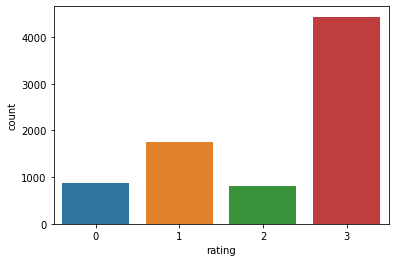

In [243]:
import seaborn as sns
sns.countplot(x='rating',data = final_df)

<AxesSubplot:xlabel='rating', ylabel='count'>

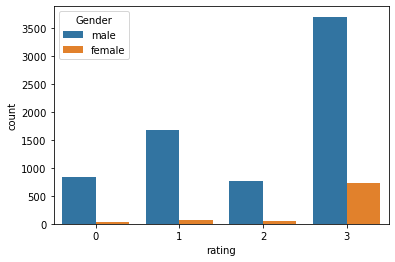

In [245]:
sns.countplot(x='rating', hue = "Gender", data = final_df)

*Ideas*
1. Scrape IMDb site for LGBT films of last 10 years to compare to popular films of last 10 years
2. Investigate if LGBT films score higher on the Bechdel test than popular films
3. Investigate if women direct films that score higher on the Bechdel test